0 0 0.20500000000000002
1 0 0.17500049999999998
2 0 0.18352579049999998
3 0 0.15980732185545002
4 0 0.12406792620302044
5 0 0.1285410027560613
6 0 0.11593868264968041
7 0 0.09666873822271667
8 0 0.08911345327696434
9 0 0.08914992917539706
10 0 0.0760049758869411
11 0 0.07511070040981892
12 0 0.06875202763244546
13 0 0.05996054040219149
14 0 0.05831964982111916
15 0 0.05351578010236779
16 0 0.049167269109917734
17 0 0.04521029623659001
18 0 0.040281298000412566
19 0 0.03693834053054922
20 0 0.035661249338207864
21 0 0.03137928355808773
22 0 0.028824775721404267
23 0 0.028037210426431074
24 0 0.025727590034201893
25 0 0.02267832317864531
26 0 0.02187916665803784
27 0 0.019262444181851215
28 0 0.017693147249860177
29 0 0.017204304528163943
30 0 0.015051866898977057
31 0 0.01383588605152454
32 0 0.012728273359792812
33 0 0.011715579487389752
34 0 0.01152095374614973
35 0 0.010554557418062705
36 0 0.009236597969536527
37 0 0.008960759657031239
38 0 0.008225455593144937
39 0 0.00726254685631

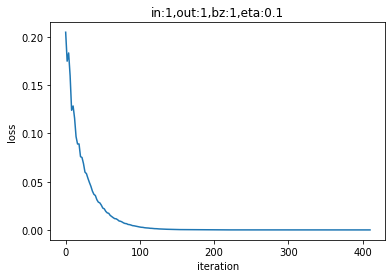

[[-0.99972117]] [[0.99984348]]


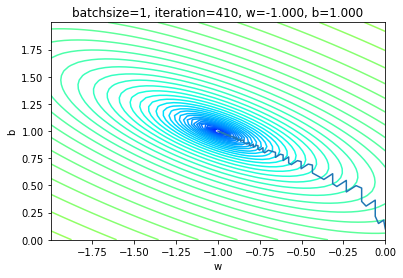

w=-0.999721,b=0.999843
[[0.99984348]] [[0.00012231]]
True


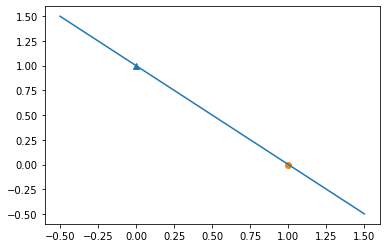

In [12]:
# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license. See LICENSE file in the project root for full license information.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm



class LogicNotGateDataReader():
    def __init__(self):
        self.num_train = 0
        self.XTrain = None
        self.YTrain = None

    # x=0,y=1; x=1,y=0
    def ReadData(self):
        X = np.array([0,1]).reshape(2,1)
        Y = np.array([1,0]).reshape(2,1)
        self.XTrain = X
        self.YTrain = Y
        self.num_train = 2
    
    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP
        
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y
    
    
    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain


class HyperParameters(object):
    def __init__(self, input_size, output_size, eta=0.1, max_epoch=1000, batch_size=5, eps=0.1):
        self.input_size = input_size
        self.output_size = output_size
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps

    def toString(self):
        title = str.format("in:{0},out:{1},bz:{2},eta:{3}", self.input_size, self.output_size, self.batch_size, self.eta)
        return title




class NeuralNet(object):
    def __init__(self, params):
        self.params = params
        self.W = np.zeros((self.params.input_size, self.params.output_size))
        self.B = np.zeros((1, self.params.output_size))

    def __forwardBatch(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        return Z

    def __backwardBatch(self, batch_x, batch_y, batch_z):
        m = batch_x.shape[0]
        dZ = batch_z - batch_y
        dB = dZ.sum(axis=0, keepdims=True)/m
        dW = np.dot(batch_x.T, dZ)/m
        return dW, dB

    def __update(self, dW, dB):
        self.W = self.W - self.params.eta * dW
        self.B = self.B - self.params.eta * dB

    def inference(self, x):
        return self.__forwardBatch(x)

    def train(self, dataReader):
        # calculate loss to decide the stop condition
        loss_history = TrainingHistory()

        if self.params.batch_size == -1:
            self.params.batch_size = dataReader.num_train
        max_iteration = (int)(dataReader.num_train / self.params.batch_size)
        for epoch in range(self.params.max_epoch):
#             print("epoch=%d" %epoch)
            dataReader.Shuffle()
            for iteration in range(max_iteration):
                # get x and y value for one sample
                batch_x, batch_y = dataReader.GetBatchTrainSamples(self.params.batch_size, iteration)
                # get z from x,y
                batch_z = self.__forwardBatch(batch_x)
                # calculate gradient of w and b
                dW, dB = self.__backwardBatch(batch_x, batch_y, batch_z)
                # update w,b
                self.__update(dW, dB)
                if iteration % 2 == 0:
                    loss = self.__checkLoss(dataReader)
                    print(epoch, iteration, loss)
                    loss_history.AddLossHistory(epoch*max_iteration+iteration, loss, self.W[0,0], self.B[0,0])
                    if loss < self.params.eps:
                        break
                    #end if
                #end if
            # end for
            if loss < self.params.eps:
                break
        # end for
        loss_history.ShowLossHistory(self.params)
        print(self.W, self.B)
   
        self.loss_contour(dataReader, loss_history, self.params.batch_size, epoch*max_iteration+iteration)

    def __checkLoss(self, dataReader):
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = self.__forwardBatch(X)
        LOSS = (Z - Y)**2
        loss = LOSS.sum()/m/2
        return loss

    def loss_contour(self, dataReader,loss_history,batch_size,iteration):
        last_loss, result_w, result_b = loss_history.GetLast()
        X,Y=dataReader.GetWholeTrainSamples()
        len1 = 50
        len2 = 50
        w = np.linspace(result_w-1,result_w+1,len1)
        b = np.linspace(result_b-1,result_b+1,len2)
        W,B = np.meshgrid(w,b)
        len = len1 * len2
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = np.dot(X, W.ravel().reshape(1,len)) + B.ravel().reshape(1,len)
        Loss1 = (Z - Y)**2
        Loss2 = Loss1.sum(axis=0,keepdims=True)/m
        Loss3 = Loss2.reshape(len1, len2)
        plt.contour(W,B,Loss3,levels=np.logspace(-5, 5, 100), norm=LogNorm(), cmap=plt.cm.jet)

        # show w,b trace
        w_history = loss_history.w_history
        b_history = loss_history.b_history
        plt.plot(w_history,b_history)
        plt.xlabel("w")
        plt.ylabel("b")
        title = str.format("batchsize={0}, iteration={1}, w={2:.3f}, b={3:.3f}", batch_size, iteration, result_w, result_b)
        plt.title(title)

        plt.axis([result_w-1,result_w+1,result_b-1,result_b+1])
        plt.show()

class TrainingHistory(object):
    def __init__(self):
        self.iteration = []
        self.loss_history = []
        self.w_history = []
        self.b_history = []

    def AddLossHistory(self, iteration, loss, w, b):
        self.iteration.append(iteration)
        self.loss_history.append(loss)
        self.w_history.append(w)
        self.b_history.append(b)

    def ShowLossHistory(self, params, xmin=None, xmax=None, ymin=None, ymax=None):
        plt.plot(self.iteration, self.loss_history)
        title = params.toString()
        plt.title(title)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        if xmin != None and ymin != None:
            plt.axis([xmin, xmax, ymin, ymax])
        plt.show()
        return title

    def GetLast(self):
        count = len(self.loss_history)
        return self.loss_history[count-1], self.w_history[count-1], self.b_history[count-1]
# end class


def Test(net):
    z1 = net.inference(0)
    z2 = net.inference(1)
    print (z1,z2)
    if np.abs(z1-1) < 0.001 and np.abs(z2-0)<0.001:
        return True
    return False

def ShowResult(net):
    x = np.array([-0.5,0,1,1.5]).reshape(4,1)
    y = net.inference(x)
    plt.plot(x,y)
    plt.scatter(0,1,marker='^')
    plt.scatter(1,0,marker='o')
    plt.show()

if __name__ == '__main__':
     # read data
    sdr = LogicNotGateDataReader()
    sdr.ReadData()
    # create net
    params = HyperParameters(1, 1, eta=0.1, max_epoch=1000, batch_size=1, eps = 1e-8)
    net = NeuralNet(params)
    net.train(sdr)
    # result
    print("w=%f,b=%f" %(net.W, net.B))
    # predication
    print(Test(net))
    ShowResult(net)
